In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!XLA_FLAGS=--xla_gpu_cuda_data_dir=/cm/shared/sw/pkg/devel/cuda/10.1.243_418.87.00

In [2]:
!XLA_FLAGS=--xla_gpu_cuda_data_dir=/cm/shared/sw/pkg/devel/cuda/10.1.243_418.87.00
from jax.config import config
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)


In [3]:
import itertools
import math
from functools import partial

import numpy as onp

import jax
print("jax version: ", jax.__version__)
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import scipy

import jax_cosmo as jc
print("jax-cosmo version:", jc.__version__)

import imnn
print("IMNN version: ", imnn.__version__)

from imnn.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from imnn.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from imnn.utils import value_and_jacrev, value_and_jacfwd

rng = jax.random.PRNGKey(0)


jax version:  0.2.10


<ipython-input-3-2c9e9f9c35c9>:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


jax-cosmo version: 0.1rc7
IMNN version:  0.3dev


In [4]:
!XLA_FLAGS=--xla_cpu_enable_fast_math=false

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Model in STAX

In [6]:
n_summaries = 2
n_s = 5000
n_d = 5000
λ = 100.0
ϵ = 0.1

In [7]:
# define inception block layer

def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3,3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5,5), strides, padding="SAME")) 
    
    maxpool = stax.serial(stax.MaxPool((3,3), padding="SAME"),
                         stax.Conv(filters4, (1,1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)
    
    
def Reshape(newshape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (newshape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs,newshape)
    return init_fun, apply_fun    


In [8]:
rng,drop_rng = jax.random.split(rng)
fs = 64 #for 128x128 sims
               

model = stax.serial(
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        #InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))
)

def get_model(filters=64):
    return stax.serial(
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))
        )

In [9]:
optimiser = optimizers.adam(step_size=1e-3)

# Random seeds for IMNN

In [10]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Random seeds for ABC

In [11]:
rng, abc_key = jax.random.split(rng)

# Fields with Jax - Cosmo

In [12]:
cosmo_fid = jc.Planck15(Omega_c=0.85, sigma8=0.75)

In [13]:
# SET 32-BiT floats for model !
θ_fid = np.array([cosmo_fid.Omega_c, cosmo_fid.sigma8], dtype=np.float32)
δθ = np.array([0.1, 0.1], dtype=np.float32)
n_params = 2
N = 32 #128
dim = 2
L = 62 #250. #84

field_shape = (N,N)
input_shape = (1,1, N,N)
simulator_args = {"N": N, "L": L, "dim": dim, "shape": field_shape, 'vol_norm': False, "N_scale": True, "squeeze": False}

In [14]:
r"""
A module defining some "nicer" fourier transform functions.
We define only two functions -- an arbitrary-dimension forward transform, and its inverse. In each case, the transform
is designed to replicate the continuous transform. That is, the transform is volume-normalised and obeys correct
Fourier conventions.
The actual FFT backend is provided by ``pyFFTW`` if it is installed, which provides a significant speedup, and
multi-threading.
Conveniently, we allow for arbitrary Fourier convention, according to the scheme in
http://mathworld.wolfram.com/FourierTransform.html. That is, we define the forward and inverse *n*-dimensional
transforms respectively as
.. math:: F(k) = \sqrt{\frac{|b|}{(2\pi)^{1-a}}}^n \int f(r) e^{-i b\mathbf{k}\cdot\mathbf{r}} d^n\mathbf{r}
and
.. math:: f(r) = \sqrt{\frac{|b|}{(2\pi)^{1+a}}}^n \int F(k) e^{+i b\mathbf{k}\cdot\mathbf{r}} d^n \mathbf{k}.
In both transforms, the corresponding co-ordinates are returned so a completely consistent transform is simple to get.
This makes switching from standard frequency to angular frequency very simple.
We note that currently, only positive values for b are implemented (in fact, using negative b is consistent, but
one must be careful that the frequencies returned are descending, rather than ascending).
"""
import jax, warnings

__all__ = ['fft', 'ifft', 'fftfreq', 'fftshift', 'ifftshift']


HAVE_FFTW = False
from jax.numpy.fft import fftn, ifftn, ifftshift as _ifftshift, fftshift as _fftshift, fftfreq as _fftfreq

# To avoid MKL-related bugs, numpy needs to be imported after pyfftw: see https://github.com/pyFFTW/pyFFTW/issues/40
#import numpy as np


def fft(X, L=None, Lk=None, a=0, b=2 * np.pi, left_edge=None, axes=None, ret_cubegrid=False):
    r"""
    Arbitrary-dimension nice Fourier Transform.
    This function wraps numpy's ``fftn`` and applies some nice properties. Notably, the returned fourier transform
    is equivalent to what would be expected from a continuous Fourier Transform (including normalisations etc.). In
    addition, arbitrary conventions are supported (see :mod:`powerbox.dft` for details).
    Default parameters have the same normalising conventions as ``numpy.fft.fftn``.
    The output object always has the zero in the centre, with monotonically increasing spectral arguments.
    Parameters
    ----------
    X : array
        An array with arbitrary dimensions defining the field to be transformed. Should correspond exactly
        to the continuous function for which it is an analogue. A lower-dimensional transform can be specified by using
        the ``axes`` argument.
    L : float or array-like, optional
        The length of the box which defines ``X``. If a scalar, each transformed dimension in ``X`` is assumed to have
        the same length. If array-like, must be of the same length as the number of transformed dimensions. The default
        returns the un-normalised DFT (same as numpy).
    Lk : float or array-like, optional
        The length of the fourier-space box which defines the dual of ``X``. Only one of L/Lk needs to be provided. If
        provided, L takes precedence. If a scalar, each transformed dimension in ``X`` is assumed to have
        the same length. If array-like, must be of the same length as the number of transformed dimensions.
    a,b : float, optional
        These define the Fourier convention used. See :mod:`powerbox.dft` for details. The defaults return the standard DFT
        as defined in :mod:`numpy.fft`.
    left_edge : float or array-like, optional
        The co-ordinate at the left-edge for each dimension that is being transformed. By default, sets the left
        edge to -L/2, so that the input is centred before transforming (i.e. equivalent to ``fftshift(fft(fftshift(X)))``)
    axes : sequence of ints, optional
        The axes to take the transform over. The default is to use all axes for the transform.
    ret_cubegrid : bool, optional
        Whether to return the entire grid of frequency magnitudes.
    Returns
    -------
    ft : array
        The DFT of X, normalised to be consistent with the continuous transform.
    freq : list of arrays
        The frequencies in each dimension, consistent with the Fourier conventions specified.
    grid : array
        Only returned if ``ret_cubegrid`` is ``True``. An array with shape given by ``axes`` specifying the magnitude
        of the frequencies at each point of the fourier transform.
    """

    if not HAVE_FFTW:
        warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")

    if axes is None:
        axes = list(range(len(X.shape)))

    N = np.array([X.shape[axis] for axis in axes])

    # Get the box volume if given the fourier-space box volume
    if L is None and Lk is None:
        L = N
    elif L is not None:  # give precedence to L
        if np.isscalar(L):
            L = L * np.ones(len(axes))
    elif Lk is not None:
        if np.isscalar(Lk):
            Lk = Lk * np.ones(len(axes))
        L = N * 2 * np.pi / (Lk * b)  # Take account of the fourier convention.

    left_edge = _set_left_edge(left_edge, axes, L)

    V = float(np.product(L))  # Volume of box
    Vx = V / np.product(N)  # Volume of cell

    ft = Vx * fftshift(fftn(X, axes=axes), axes=axes) * np.sqrt(np.abs(b) / (2 * np.pi) ** (1 - a)) ** len(axes)

    dx = np.array([float(l) / float(n) for l, n in zip(L, N)])

    freq = np.array([fftfreq(n, d=d, b=b) for n, d in zip(N, dx)])

    # Adjust phases of the result to align with the left edge properly.
    ft = _adjust_phase(ft, left_edge, freq, axes, b)
    return _retfunc(ft, freq, axes, ret_cubegrid)


def ifft(X, Lk=None, L=None, a=0, b=2 * np.pi, axes=None, left_edge=None, ret_cubegrid=False):
    r"""
    Arbitrary-dimension nice inverse Fourier Transform.
    This function wraps numpy's ``ifftn`` and applies some nice properties. Notably, the returned fourier transform
    is equivalent to what would be expected from a continuous inverse Fourier Transform (including normalisations etc.).
    In addition, arbitrary conventions are supported (see :mod:`powerbox.dft` for details).
    Default parameters have the same normalising conventions as ``numpy.fft.ifftn``.
    Parameters
    ----------
    X : array
        An array with arbitrary dimensions defining the field to be transformed. Should correspond exactly
        to the continuous function for which it is an analogue. A lower-dimensional transform can be specified by using
        the ``axes`` argument. Note that if using a non-periodic function, the co-ordinates should be monotonically
        increasing.
    Lk : float or array-like, optional
        The length of the box which defines ``X``. If a scalar, each transformed dimension in ``X`` is assumed to have
        the same length. If array-like, must be of the same length as the number of transformed dimensions. The default
        returns the un-normalised DFT (the same as numpy).
    L : float or array-like, optional
        The length of the real-space box, defining the dual of ``X``. Only one of Lk/L needs to be passed. If L is
        passed, it is used. If a scalar, each transformed dimension in ``X`` is assumed to have
        the same length. If array-like, must be of the same length as the number of transformed dimensions. The default
        of ``Lk=1`` returns the un-normalised DFT.
    a,b : float, optional
        These define the Fourier convention used. See :mod:`powerbox.dft` for details. The defaults return the standard DFT
        as defined in :mod:`numpy.fft`.
    axes : sequence of ints, optional
        The axes to take the transform over. The default is to use all axes for the transform.
    left_edge : float or array-like, optional
        The co-ordinate at the left-edge (in k-space) for each dimension that is being transformed. By default, sets the
        left edge to -Lk/2, equivalent to the standard numpy ifft. This affects only the phases of the result.
    ret_cubegrid : bool, optional
        Whether to return the entire grid of real-space co-ordinate magnitudes.
    Returns
    -------
    ft : array
        The IDFT of X, normalised to be consistent with the continuous transform.
    freq : list of arrays
        The real-space co-ordinate grid in each dimension, consistent with the Fourier conventions specified.
    grid : array
        Only returned if ``ret_cubegrid`` is ``True``. An array with shape given by ``axes`` specifying the magnitude
        of the real-space co-ordinates at each point of the inverse fourier transform.
    """

    if not HAVE_FFTW:
        warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")

    if axes is None:
        axes = list(range(len(X.shape)))

    N = np.array([X.shape[axis] for axis in axes])

    # Get the box volume if given the real-space box volume
    if Lk is None and L is None:
        Lk = 1
    elif L is not None:
        if np.isscalar(L):
            L = np.array([L] * len(axes))

        dx = np.array(L) / N
        Lk = 2 * np.pi / (dx * b)

    elif np.isscalar(Lk):
        Lk = [Lk] * len(axes)

    Lk = np.array(Lk)
    left_edge = _set_left_edge(left_edge, axes, Lk)

    V = np.product(Lk)
    dk = np.array([float(lk) / float(n) for lk, n in zip(Lk, N)])

    ft = V * ifftn(X, axes=axes) * np.sqrt(np.abs(b) / (2 * np.pi) ** (1 + a)) ** len(axes)
    ft = ifftshift(ft, axes=axes)

    freq = np.array([fftfreq(n, d=d, b=b) for n, d in zip(N, dk)])

    ft = _adjust_phase(ft, left_edge, freq, axes, -b)
    return _retfunc(ft, freq, axes, ret_cubegrid)


def _adjust_phase(ft, left_edge, freq, axes, b):
    for i, (l, f) in enumerate(zip(left_edge, freq)):
        xp = np.exp(-b * 1j * f * l)
        obj = tuple([None] * axes[i]) + (slice(None, None, None),) + tuple([None] * (ft.ndim - axes[i] - 1))
        ft *= xp[obj]
    return ft


def _set_left_edge(left_edge, axes, L):
    if left_edge is None:
        left_edge = [-l/2. for l in L]
    else:
        if np.isscalar(left_edge):
            left_edge = [left_edge] * len(axes)
        else:
            assert len(left_edge) == len(axes)

    return left_edge


def _retfunc(ft, freq, axes, ret_cubegrid):
    if not ret_cubegrid:
        return ft, freq
    else:
        grid = freq[0] ** 2
        for i in range(1, len(axes)):
            grid = np.add.outer(grid, freq[i] ** 2)

        return ft, freq, np.sqrt(grid)


def fftshift(x, *args, **kwargs):
    """
    The same as numpy's fftshift, except that it preserves units (if Astropy quantities are used)
    
    All extra arguments are passed directly to numpy's `fftshift`.
    """
    out = _fftshift(x, *args, **kwargs)

    if hasattr(x, "unit"):
        return out * x.unit
    else:
        return out


def ifftshift(x, *args, **kwargs):
    """
    The same as numpy's ifftshift, except that it preserves units (if Astropy quantities are used)
    All extra arguments are passed directly to numpy's `ifftshift`.
    """
    out = _ifftshift(x, *args, **kwargs)

    if hasattr(x, "unit"):
        return out * x.unit
    else:
        return out


def fftfreq(N, d=1.0, b=2 * np.pi):
    """
    Return the fourier frequencies for a box with N cells, using general Fourier convention.
    Parameters
    ----------
    N : int
        The number of grid cells
    d : float, optional
        The interval between cells
    b : float, optional
        The fourier-convention of the frequency component (see :mod:`powerbox.dft` for details).
    Returns
    -------
    freq : array
        The N symmetric frequency components of the Fourier transform. Always centred at 0.
    """
    return fftshift(_fftfreq(N, d=d)) * (2 * np.pi / b)

In [15]:
# define noise
rng,fg_key = jax.random.split(rng)
foregrounds = jax.random.normal(fg_key, (1000, 1,) + simulator_args['shape'])*0


def simulator(rng, θ, simulator_args=simulator_args):
    def P(k, A=1, B=1):
        # define cosmology with parameters
        cosmo = jc.Planck15(Omega_c=A, sigma8=B)
        return jc.power.linear_matter_power(cosmo, k)

    
    def fn(key, A, B):
        
        shape = simulator_args["shape"]
        
        k = np.sqrt(np.sum(np.array(np.meshgrid(*(
            (np.hstack((np.arange(0, _shape//2 + 1), 
                np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape)**2
                for _shape in shape))), axis=0))
        
        new_shape = ()
        for _shape in shape:
            if _shape % 2 == 0:
                new_shape += (_shape+1,)
            else:
                new_shape += (_shape,)
        
        
        key1,key2 = jax.random.split(key)
        
        foreground = foregrounds[jax.random.randint(key2, 
                                        minval=0, maxval=1000, shape=())]
        
        # L is in length units, like Gpc
        L = simulator_args['L']
        dim = simulator_args['dim']
        
        if np.isscalar(L):
            L = [L]*int(dim)
        
        else:
            L = np.array(L)
            
        
        V = np.prod(np.array(L))
        
        scale = V**(1./dim)
        
        Lk = ()
        
        _N = 1
        for i,_shape in enumerate(shape):
            _N *= _shape
            Lk += (_shape / L[i],) # 1 / dx
            
    
        # ifft is N/L
        # fft is L/N
        
        fft_norm = np.prod(np.array(Lk))
        #fft_norm = 1 / ifft_norm
        
        _dims = len(shape)
        tpl = ()
        for _d in range(_dims):
            tpl += (_d,)


        # POWERBOX IMPLEMENTATION

        mag = jax.random.normal(key1, shape=tuple(N for N in new_shape))
        # random phases
        pha = 2 * np.pi * jax.random.uniform(key1, shape=tuple(N for N in new_shape))
        # now make hermitian field (reality condition)
        revidx = (slice(None, None, -1),) * len(mag.shape)      
        mag = (mag + mag[revidx]) / np.sqrt(2) 
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha)) # output is complex
        
        cutidx = (slice(None, -1),) * len(new_shape)
        dk = dk[cutidx]
        
        # power spectrum
        powers = np.concatenate((np.zeros(1), 
                    np.sqrt(P(k.flatten()[1:], A=A, B=B)))).reshape(k.shape)

        
        # normalize power by volume
        if simulator_args['vol_norm']:
            powers /= V
            #fft_norm *= V
            
      
        
        # do lognormal transformation
        powers = np.real(np.fft.ifftshift(np.fft.ifftn(powers)*fft_norm)*V)

    
        powers = np.log(1. + powers)
        powers = np.abs(np.fft.fftn(powers))  # CHANGED THIS
        
        # now multiply by random field
        fourier_field = powers * dk
        
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(len(shape), dtype=int),
            np.zeros((1,)))
        
        
        field = np.sqrt(V) * np.real(np.fft.ifftn(fourier_field))*fft_norm # CHANGED THIS
        
        
        sg = np.var(field)
        field = np.exp(field - sg / 2.) - 1.
        
                
        field = np.expand_dims(field, (0,))
        
        
        if simulator_args["N_scale"]:
            field *= scale
        
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0,))

        return np.array(np.real((field)), dtype='float32')
        
    shape = simulator_args["shape"]
    # unpack parameters Omega_c, sigma8
    A,B = θ
    cosmo = jc.Planck15(Omega_c=A, sigma8=B)
    #k = np.sqrt(np.sum(np.array(np.meshgrid(*(((2. * np.pi) / N) * np.arange(N // 2) for N in shape)))**2., 0))
    #return fn(key, A, B)
    
    
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, B)

## sim and gradient

In [16]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

In [17]:
rng, key = jax.random.split(rng)

In [18]:
# plot example simulation and derivative # L = 250
deriv_args = {"N": 128, "L": 250., "dim": 2, "shape": (128,128), "vol_norm": True, "N_scale": False, "squeeze": False}
simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, simulator_args=deriv_args)

/mnt/home/tmakinen/anaconda3/envs/pyjax9/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


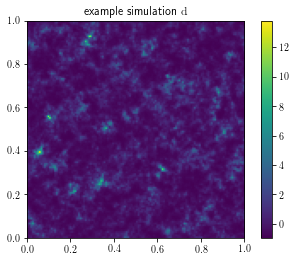

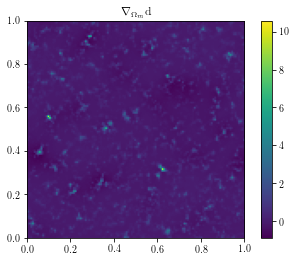

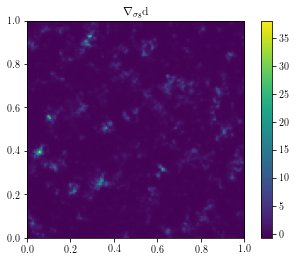

In [19]:
%matplotlib inline
#plt.style.use('default')
plt.imshow(np.squeeze(simulation[0]), extent=(0,1,0,1))
plt.colorbar()
plt.title(r'example simulation $\rm d$')
#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/cosmo-cutout')
plt.show()

plt.imshow(np.squeeze(simulation_gradient).T[0].T, extent=(0,1,0,1))
plt.title(r'$\nabla_{\Omega_m} \rm d$')
plt.colorbar()
#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/cosmo-dOmM')
plt.show()

plt.imshow(np.squeeze(simulation_gradient).T[1].T, extent=(0,1,0,1))
plt.title(r'$\nabla_{\sigma_8} \rm d$')
plt.colorbar()
#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/cosmo-dSig8')
plt.show()

# numerical Fisher information

In [20]:
class analyticFieldLikelihood:

    def __init__(self, 
                 field_shape,
                 Δ,
                 prior,
                 k,
                 pk,
                 L,
                 dim=2,
                 gridsize=20, 
                 tiling=2):

        """code for computing a gaussian field's likelihood for power spectrum parameters
            PBJ :         powerBox simulator object
            field_shape : list. shape of field input
            Δ :           array-like. FFT of the real-space field
            prior :       array-like. range over which to compute the likelihood
            k :           array-like. fourier modes over which to compute P(k)
            tiling :      list or int. tiling=2 means likelihood will be computed as 2x2 grid
            gridsize :    how large to make the likelihood surface
        """
        
        
       # if k is None:
       #     self.k = PBJ.k

       # if pk is None:
       #     self.pk = PBJ.pk
        self.pk = pk
        self.k = k
        self.L = L
        

        self.field_shape = field_shape
        self.gridsize = gridsize
        if np.isscalar(tiling):
            self.tiling = [tiling]*2
        else:
            self.tiling = tiling    
        #self.tilesize = gridsize // tiling
        self.N = np.sqrt(np.prod(np.array(field_shape)))  # should just be N for NxN grid
        self.prior = prior

        self.k = k
        self.Δ = Δ

    def Pk(self, k, A=1, B=0.5):
        return self.pk(k, A, B) / L**dim


        return np.diag(pk)
    def log_likelihood(self, k, A, B, Δ):
        Δ = Δ.flatten()[:]
        k = k

        dlength = len(k.flatten())

        def fn(_A, _B):

            nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
            nrm = jax.ops.index_update(
              nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
            nrm = 1

            powers = self.Pk(k.flatten()[:], A=_A, B=_B)

            # covariance is P(k)
            C = powers * nrm
            invC = 1./self.Pk(k.flatten()[:], A=_A, B=_B)

            logdetC = np.sum(np.log(C))
            pi2 = np.pi * 2.
            m_half_size = -0.5 * len(Δ)
            exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ)
            norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
            return (exponent + norm)
        return jax.vmap(fn)(A, B)

    def get_likelihood(self, return_grid=False, shift=None):
        A_start = self.prior[0][0]
        A_end = self.prior[1][0]
        B_start = self.prior[0][1]
        B_end = self.prior[1][1]

        region_size = [self.gridsize // self.tiling[i] for i in range(len(self.tiling))]

        print("computing likelihood on a %dx%d grid \n \
        in tiles of size %dx%d"%(self.gridsize, self.gridsize, region_size[0], region_size[1]))


        def get_like_region(A0, A1, B0, B1, qsize):
            A_range = np.linspace(A0, A1, qsize)
            B_range = np.linspace(B0, B1, qsize)
            A, B = np.meshgrid(A_range, B_range)

            return (self.log_likelihood(self.k,
                A.ravel(), B.ravel(), self.Δ).reshape(qsize,qsize))



        A_incr = (A_end - A_start) / self.tiling[0]
        B_incr = (B_end - B_start) / self.tiling[1]

        # marks the ends of linspace
        A_starts = [A_start + (i)*A_incr for i in range(self.tiling[0])]
        A_ends = [A_start + (i+1)*A_incr for i in range(self.tiling[0])]
        B_starts = [B_start + (i)*B_incr for i in range(self.tiling[1])]
        B_ends = [B_start + (i+1)*B_incr for i in range(self.tiling[1])]

        _like_cols = []
        for _col in range(self.tiling[0]):
            # slide horizontally in A
            _like_row = []
            for _row in range(self.tiling[1]):
                # slide vertically in B

                _like = get_like_region(A_starts[_row], 
                                        A_ends[_row], 
                                        B_starts[_col], 
                                        B_ends[_col],
                                        region_size[0],
                                        )
                _like_row.append(_like)

            _like_cols.append(np.concatenate(_like_row, axis=1))

        _log_likelihood = np.real(np.concatenate(_like_cols, axis=0))

        if shift is None:
            shift = np.max(_log_likelihood)

        print('shift', shift)
        print('loglike mean', np.mean(_log_likelihood))

        #_log_likelihood = _log_likelihood - shift

        if return_grid:
            _A_range = np.linspace(self.prior[0,0], self.prior[1,0], self.gridsize)
            _B_range = np.linspace(self.prior[0,0], self.prior[1,0], self.gridsize)
            return (_log_likelihood), _A_range, _B_range

        return (_log_likelihood)



    def plot_contours(self, ax=None, 
                      θ_ref=None, shift=None, 
                      xlabel=r'$\Omega_m$', ylabel=r'$\sigma_8$', 
                      return_like=True):

        _like, _A, _B = self.get_likelihood(return_grid=True, shift=shift)


        _A, _B = np.meshgrid(_A, _B)

        if ax is None:
            fig,ax = plt.subplots(figsize=(10,10))

        mesh = ax.contourf(_A, _B, _like)
        plt.colorbar(mesh, ax=ax)

        if θ_ref is not None:
            ax.scatter(θ_ref[0], θ_ref[1], zorder=10, marker='+', s=100, color='r')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        if return_like:
            return _like, ax

        else:
            return ax
        

    def plot_corner(self, ax=None, θ_ref=None, label="Analytic likelihood", 
                    image_data=None, return_like=False):

        _like, _A_range, _B_range = self.get_likelihood(return_grid=True)

        likelihoodA = scipy.special.softmax(np.real(_like)).sum(0) #np.real(likelihood).sum(0)
        likelihoodA /= likelihoodA.sum() * (_A_range[1] -  _A_range[0])
        likelihoodB =  scipy.special.softmax(np.real(_like)).sum(1) #np.real(likelihood).sum(1)
        likelihoodB /= likelihoodB.sum() * (_B_range[1] -  _B_range[0])

        _like = scipy.special.softmax(np.real(_like))
        sorted_marginal = np.sort(_like.flatten())[::-1]
        cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
        value = []
        for level in [0.997, 0.95, 0.68]:
            this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
            if len(value) == 0:
                value.append(this_value)
            elif this_value <= value[-1]:
                break
            else:
                value.append(this_value)

        if ax is None:
            fig,ax = plt.subplots(nrows=2, ncols=2)

        ax[1,0].contour(_A_range, _B_range, _like, levels=value, colors='C2', alpha=0.7)
        ax[0,0].plot(_A_range, likelihoodA, color='C2', label=None, alpha=0.7)
        ax[1,1].plot(likelihoodB, _B_range, color='C2', label='loglike', alpha=0.7)
        
        if image_data is not None:
            ax[0,1].imshow(np.squeeze(image_data))
        else:
            ax[0,1].axis("off")

        if θ_ref is not None:
            ax[0,0].axvline(θ_ref[0], linestyle='--', c='k')
            ax[1,0].axvline(θ_ref[0], linestyle='--', c='k')
            ax[1,0].axhline(θ_ref[1], linestyle='--', c='k')
            ax[1,1].axhline(θ_ref[1], linestyle='--', c='k', label=r'$\theta_{\rm ref}$')

        ax[1,0].set_xlabel(r'$A$')
        ax[1,0].set_ylabel(r'$B$')
        
        if return_like:
            return ax,_like

        else:
            return ax



In [21]:
shape = (N,N)
kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    (np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape)**2
        for _shape in shape))), axis=0))

def cosmo_pk(k, A=1, B=1):
    # define cosmology with parameters
    cosmo = jc.Planck15(Omega_c=A, sigma8=B)
    return jc.power.linear_matter_power(cosmo, k)

In [22]:
simulator_args

{'N': 32,
 'L': 62,
 'dim': 2,
 'shape': (32, 32),
 'vol_norm': False,
 'N_scale': True,
 'squeeze': False}

In [23]:
gridsize = 20                # for likelihood gridding
Δ = np.fft.fftn((np.squeeze(simulation)))[1:N//2, 1:N//2] / (N/L)**2
k = kbin[1:N//2, 1:N//2]  
prior_range = np.array([[0.2, 0.2], [2.0, 1.5]])
AL = analyticFieldLikelihood(field_shape, Δ, prior_range, k, pk=cosmo_pk, L=L, gridsize=gridsize, tiling=[5,5])

computing likelihood on a 20x20 grid 
         in tiles of size 4x4


/mnt/home/tmakinen/anaconda3/envs/pyjax9/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


shift -3706392.5
loglike mean -96846860.0


<ipython-input-20-65cf0ff67364>:202: UserWarning: No contour levels were found within the data range.
  ax[1,0].contour(_A_range, _B_range, _like, levels=value, colors='C2', alpha=0.7)


CPU times: user 7min 19s, sys: 26.8 s, total: 7min 46s
Wall time: 4min 14s


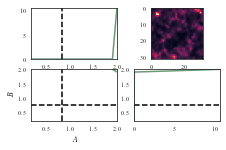

In [56]:
%%time 
ax = AL.plot_corner(θ_ref=θ_fid, image_data=simulation)

In [101]:
sim_args = {"N": N, "L": L, "dim": 2, "shape": field_shape, "vol_norm": True, "N_scale": False, "squeeze": False}

def sanity_check(gridsize=50, num=20):
    likes = []
    likeAs = []
    likeBs = []
    rng1 = jax.random.PRNGKey(13)
    values = []
    θ_sim = np.array([0.8, 0.8], dtype=np.float32)

    for t in range(num):
        key, rng1 = jax.random.split(rng1)
        targ = simulator(key, θ_sim, simulator_args=sim_args)

        gridsize = 50                # for likelihood gridding
        Δ = np.fft.fftn(np.squeeze(targ))[1:N//2, 1:N//2]
        k = kbin[1:N//2, 1:N//2]  
        prior_range = np.array([[0.1, 0.1], [1.25, 1.25]])
        AL = analyticFieldLikelihood(field_shape, Δ, prior_range, k, cosmo_pk, 
                                     gridsize=gridsize, tiling=[5,5])

        likelihood,A_range,B_range = AL.get_likelihood(shift=None, return_grid=True)


        _A_range = A_range#*np.exp(shift)
        _B_range = B_range#*np.exp(shift)

        likelihoodA = scipy.special.softmax(np.real(likelihood)).sum(0) #np.real(likelihood).sum(0)
        likelihoodA /= likelihoodA.sum() * (_A_range[1] -  _A_range[0])
        likelihoodB =  scipy.special.softmax(np.real(likelihood)).sum(1) #np.real(likelihood).sum(1)
        likelihoodB /= likelihoodB.sum() * (_B_range[1] -  _B_range[0])

        likelihood = scipy.special.softmax(np.real(likelihood))
        sorted_marginal = np.sort(likelihood.flatten())[::-1]
        cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
        value = []
        for level in [0.997, 0.95, 0.68]:
            this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
            if len(value) == 0:
                value.append(this_value)
            elif this_value <= value[-1]:
                break
            else:
                value.append(this_value)
        #fig, ax = plt.subplots(2, 2, figsize=(10, 10))

        #likelihood /= likelihood.sum()

        likes.append(likelihood)
        likeAs.append(likelihoodA)
        likeBs.append(likelihoodB)

        values.append(value)
        
        return likes,likeAs,likeBs,values,A_range,B_range

computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -760.4763576960784
loglike mean -2226.3879935449118


Text(0, 0.5, '$\\sigma_8$')

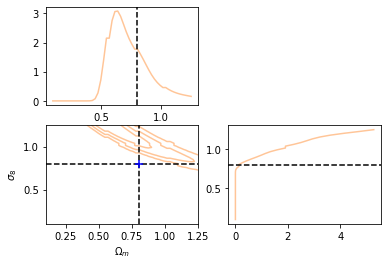

In [102]:
likes,likeAs,likeBs,values,A_range,B_range = sanity_check(gridsize=20, num=5)

θ_sim = np.array([0.8, 0.8], dtype=np.float32)
fig,ax = plt.subplots(nrows=2, ncols=2)

for l,like in enumerate(likes):
    ax[1,0].contour(A_range, B_range, like, levels=values[l], colors='#FF8D33', alpha=0.5)
    ax[0, 0].plot(A_range, likeAs[l], color='#FF8D33', label=None, alpha=0.5)
    ax[0, 1].axis("off")
    ax[1, 1].plot(likeBs[l], B_range, color='#FF8D33', label='loglike', alpha=0.5)
    
ax[1,0].scatter(θ_sim[0], θ_sim[1], marker='+', s=50, color='blue', zorder=20)
ax[0,0].axvline(θ_sim[0], linestyle='--', c='k')
ax[1,0].axvline(θ_sim[0], linestyle='--', c='k')
ax[1,0].axhline(θ_sim[1], linestyle='--', c='k')
ax[1,1].axhline(θ_sim[1], linestyle='--', c='k', label=r'$\theta_{\rm sim}$')

ax[1,0].set_xlabel(r'$\Omega_m$')
ax[1,0].set_ylabel(r'$\sigma_8$')

# numerical Fisher

In [24]:
# compute numerical fisher information
shape = (N,N)
kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    (np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape)**2
        for _shape in shape))), axis=0))

def cosmo_pk(k, A=1, B=1):
    # define cosmology with parameters
    cosmo = jc.Planck15(Omega_c=A, sigma8=B)
    return jc.power.linear_matter_power(cosmo, k)

def log_likelihood(k, A, B, Δ, pk, L):
    Δ = Δ.flatten()[:]
    k = k
    _A = A
    _B = B
    
    dlength = len(k.flatten())

    nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
    nrm = jax.ops.index_update(
      nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
    nrm = 1

    powers = pk(k.flatten()[:], A=_A, B=_B) #* L**2

    # covariance is P(k)
    C = powers * nrm
    invC = 1./ powers

    logdetC = np.sum(np.log(C))
    pi2 = np.pi * 2.
    m_half_size = -0.5 * len(Δ)
    exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ)
    norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
    return np.real(exponent + norm)

sim_args = {"N": N, "L": L, "dim": 2, "shape": field_shape, "vol_norm": True, "N_scale": False, "squeeze": False}


def score(A, B, key):
    θ = np.array([A,B])
    L = 62.
    sim = simulator(key, θ, simulator_args=sim_args)
    Δ = np.fft.fftn(np.squeeze(sim))[1:N//2, 1:N//2]
    k = kbin[1:N//2, 1:N//2]
    pk = cosmo_pk
    
    return log_likelihood(k, A, B, Δ, pk, L)

@jax.jit
def dlnLdθ(A, B, key):
    return jax.grad(score, argnums=(0, 1))(A, B, key)

def numeric_F(A, B, key, n_samples):
    keys = np.array(jax.random.split(key, num=n_samples))
    return np.cov(np.array(jax.vmap(dlnLdθ)(np.repeat(A, n_samples), np.repeat(B, n_samples), keys)))

In [72]:
rng, key = jax.random.split(rng)
_a,_b = θ_fid
F_expected = numeric_F(np.array(_a), np.array(_b), key, 20)
detF_expected = np.linalg.det(F_expected)

print('expected F: ', F_expected)
print('expected det F: ', detF_expected)


expected F:  [[0.02416238 0.07165013]
 [0.07165013 0.23474698]]
expected det F:  0.0005383034


In [51]:
rng, key = jax.random.split(rng)
_a,_b = θ_fid

_detFs = []
_Fs = [] 
for i in range(40):
    rng, key = jax.random.split(rng)
    F_expected = numeric_F(np.array(_a), np.array(_b), key, 30)
    _detFs.append(np.linalg.det(F_expected))
    _Fs.append(F_expected)
    
detF_expected = np.mean(np.array(_detFs))
F_expected = np.mean(np.array(_Fs), axis=0)
print('expected F: ', F_expected)
print('expected det F: ', detF_expected)

expected F:  [[ 45.74586 119.40853]
 [119.40853 312.98715]]
expected det F:  57.02253


# Make Target Data for iterative IMNN training
We're going to create target data with Planck cosmological paramters and iterate our poorly-trained fiducial IMNN towards the correct compression.

In [25]:
#simulator_args = {"N": N, "L": 250, "dim": dim, "shape": (128,128), "N_scale": False, "vol_norm": True, "squeeze": True}
simulator_args = {"N": N, "L": L, "dim": dim, "shape": (N,N), "N_scale": False, "vol_norm": True, "squeeze": True}
cosmo_target = jc.Planck15()
θ_target = np.array([cosmo_target.Omega_c, cosmo_target.sigma8])

rng, key = jax.random.split(rng)
#θ_target = np.array([0.4, 0.85])
target_data = simulator(
    key,
    θ_target,
    simulator_args={**simulator_args, **{'squeeze':False}})

/mnt/home/tmakinen/anaconda3/envs/pyjax9/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [26]:
target_data = np.expand_dims(target_data, 0)
target_data.shape

(1, 1, 1, 32, 32)

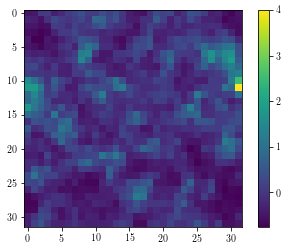

In [27]:
plt.imshow(np.squeeze(target_data))
plt.colorbar()

# Initialise IMNN

In [28]:
simulator_args["squeeze"] = False

In [29]:
simulator_args['vol_norm'] = True
simulator_args['N_scale'] = False # false 
simulator_args['L'] = L

In [30]:
simulator_args

{'N': 32,
 'L': 62,
 'dim': 2,
 'shape': (32, 32),
 'N_scale': False,
 'vol_norm': True,
 'squeeze': False}

In [41]:
# SAVING IMNN ATTRIBUTES
import cloudpickle as pickle
import os

def save_weights(IMNN, folder_name='./model', weights='final'):
    
    # create output directory
    if not os.path.exists(folder_name): 
        os.mkdir(folder_name)
    
    def pckl_me(obj, path):
        with open(path, 'wb') as file_pi:
            pickle.dump(obj, file_pi)
        file_pi.close()
        
    # save IMNN (optimiser) state:
    savestate = jax.experimental.optimizers.unpack_optimizer_state(IMNN.state)
    pckl_me(savestate, os.path.join(folder_name, 'IMNN_state'))
    
    # save weights
    if weights == 'final':
        np.save(os.path.join(folder_name, 'final_w'), IMNN.final_w)
    
    else:
        np.save(os.path.join(folder_name, 'best_w'), IMNN.best_w)
        
    # save initial weights
    np.save(os.path.join(folder_name, 'initial_w'), IMNN.initial_w)
        
    # save training history
    pckl_me(IMNN.history, os.path.join(folder_name, 'history'))
    
    # save important attributes as a dict
    imnn_attributes = {
        'n_s': IMNN.n_s,
        'n_d': IMNN.n_d,
        'input_shape': IMNN.input_shape,
        'n_params' : IMNN.n_params,            
        'n_summaries': IMNN.n_summaries,
        'θ_fid': IMNN.θ_fid,
        'F': IMNN.F,   
        'validate': IMNN.validate,
        'simulate': IMNN.simulate,
        
    }
    
    pckl_me(imnn_attributes, os.path.join(folder_name, 'IMNN_attributes'))
    
    print('saved weights and attributes to the file ', folder_name)
    
    
def load_weights(IMNN, folder_name='./model', weights='final', load_attributes=True):
    
    
    def unpckl_me(path):
        file = open(path, 'rb')
        return pickle.load(file)
    
    # load and assign weights
    if weights=='final':
        weights = np.load(os.path.join(folder_name, 'final_w.npy'),  allow_pickle=True)
        IMNN.final_w = weights
    else:
        weights = np.load(os.path.join(folder_name, 'best_w.npy'),  allow_pickle=True)
        IMNN.best_w = weights
        
    # re-pack and load the optimiser state
    loadstate = unpckl_me(os.path.join(folder_name, 'IMNN_state'))
    IMNN.state = jax.experimental.optimizers.pack_optimizer_state(loadstate)
    
    
    # load history
    IMNN.history = unpckl_me(os.path.join(folder_name, 'history'))
    
    # load important attributes
    if load_attributes:
        IMNN.intial_w =  np.load(os.path.join(folder_name, 'initial_w.npy'), allow_pickle=True)
        attributes = unpckl_me(os.path.join(folder_name, 'IMNN_attributes'))
        IMNN.θ_fid = attributes['θ_fid']
        IMNN.n_s = attributes['n_s']
        IMNN.n_d = attributes['n_d']
        IMNN.input_shape = attributes['input_shape']
        
    print('loaded IMNN with these attributes: ', attributes)
    

In [32]:
IMNN = AggregatedSimulatorIMNN(
        n_s=5000,
        n_d=5000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=initial_model_key,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
        host=jax.devices()[0],
        devices=[jax.devices()[0]],
        n_per_device=1000
        )

# Iterative Fitting

In [33]:
θ_fid

DeviceArray([0.85, 0.75], dtype=float32)

In [34]:
%%time
for i in range(1):
    rng,fit_rng = jax.random.split(rng)
    IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500) #for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs);
    
#save_weights(IMNN, folder_name='./big_incept128')

CPU times: user 18min 39s, sys: 3min 3s, total: 21min 43s
Wall time: 21min 39s


In [42]:
detF_expected

DeviceArray(9628.463, dtype=float32)

In [44]:
np.linalg.det(IMNN.F)

DeviceArray(837.87366, dtype=float32)

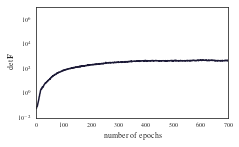

In [37]:
latexify(fig_width=3.37)
plt.plot(IMNN.history['detF'][:])
#plt.plot(np.ones(len(IMNN.history['detF'][:]))*detF_expected, c='k', linestyle='--')
plt.ylim(1e-2, 1e7)
plt.ylabel(r'$\det \textbf{F}$')
plt.xlabel('number of epochs')
plt.yscale('log')
plt.tight_layout()
#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-training.png', dpi=400)

In [42]:
save_weights(IMNN, folder_name='./cosmo-test')

saved weights and attributes to the file  ./cosmo-test


In [43]:
load_weights(IMNN, folder_name='./cosmo-test')

loaded IMNN with these attributes:  {'n_s': 5000, 'n_d': 5000, 'input_shape': (1, 1, 32, 32), 'n_params': 2, 'n_summaries': 2, 'θ_fid': array([0.85, 0.75], dtype=float32), 'F': array([[ 30.005684,  59.242626],
       [ 59.242622, 133.12448 ]], dtype=float32), 'validate': False, 'simulate': True}


In [44]:
IMNN.set_F_statistics(w=IMNN.w, key=rng)

In [30]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = np.array(jax.random.split(
            seed, 
            num=len(self.event_shape)))
        return jax.vmap(
            lambda key, low, high : jax.random.uniform(
                key, 
                shape=(n,), 
                minval=low, 
                maxval=high))(
            keys, self.low, self.high)
            
def iterative_training(target_data, 
                       IMNN_chain, 
                       θ_fid, 
                       θ_target, 
                       prior, 
                       rng, 
                       criterion=None,
                       kbin=None,
                       detf_expected=None, 
                       start_with_last=False, do_train=True):
    
    
    def training_loop(IMNN_chain, 
                      θ_fid, prior, 
                      rng, 
                      detf_expected, 
                      θ_target, 
                      itr=0,
                      start_with_last=False,
                      do_train=True,
                      plot_training=True, plot_GA=True):
        

        # set up random keys
        rng, initial_model_key = jax.random.split(rng)
        rng, fitting_key = jax.random.split(rng)

        # get model
        model = get_model(filters=64)
        optimiser = optimizers.adam(step_size=1e-3)
        
        if start_with_last:
            IMNN = IMNN_chain[-1]
        
        else: 
            IMNN = AggregatedSimulatorIMNN(
                        n_s=5000,
                        n_d=5000,
                        n_params=n_params,
                        n_summaries=n_summaries,
                        input_shape=input_shape,
                        θ_fid=θ_fid,
                        model=model,
                        optimiser=optimiser,
                        key_or_state=initial_model_key,
                        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
                        host=jax.devices()[0],
                        devices=[jax.devices()[0]],
                        n_per_device=1000
                        )

        # fit IMNN in loop -- we want to extract >70% of the expected fisher
        fisher_ratio = 0.
        if do_train:
            print('training IMNN for iteration %d'%(itr))

            rng,fit_rng = jax.random.split(rng)
            IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500)

            if plot_training:
                # display training progress
                plt.plot(IMNN.history['detF'][:])
                plt.ylabel(r'$\det F$')
                plt.xlabel('number of epochs')
                plt.yscale('log')
                plt.show()

        
        # save the IMNN
        IMNN_chain.append(IMNN)
        
        
        # next, get the Fisher estimates and see if we've moved more than 1-sigma away from either
        # fiducial parameters
        
        # first get IMNN estimate
        estimates = np.squeeze(IMNN.get_estimate(target_data))
        
        # then get uncertainties on parameters from IMNN.invF
        a_std = np.sqrt(IMNN.invF[0,0])
        a_mu = estimates[0]
        
        b_std = np.sqrt(IMNN.invF[1,1])
        b_mu = estimates[1]
        
        # determine how far away we've moved from θ_fid: 
        a_dist = np.abs(a_mu - θ_fid[0])      
        b_dist = np.abs(b_mu - θ_fid[1])
        
        print('A GA mean: {} +\- {}'.format(a_mu, a_std))
        print('A_fid: {}'.format(θ_fid[0]))
        
        print('B GA mean: {} +\- {}'.format(b_mu, b_std))
        print('B_fid: {}'.format(θ_fid[1]))
        
        
        # plot our GA if asked:
        if plot_GA:
            prior = prior
            GA = GaussianApproximation(IMNN.get_estimate(target_data), IMNN.invF, prior)

            new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
            fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))

            GA.marginal_plot(ax=ax, colours=new_colors[2], 
                axis_labels=[r"$\Omega_m$", r"$\sigma_8$"], label='Gaussian Approx. %d'%(itr), ncol=1)

            ax[0,1].imshow(np.squeeze(target_data))

            ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
            ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
            ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
            ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

            ax[1,0].set_xlabel(r'$\Omega_m$')
            ax[1,0].set_ylabel(r'$\sigma_8$')

            ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
            ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
            ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
            ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

            ax[1,1].legend(framealpha=0.)

            ax[0,0].legend(framealpha=0.)

            plt.show()

        
        
        return a_mu,b_mu,a_dist,b_dist,a_std,b_std,IMNN_chain
        

        
    a_std = 0.
    b_std = 0.
    a_dist = 1000.
    b_dist = 1000.
    
    itr = 0
    
    if criterion is None:
        criterion = 1.0

    
    while (a_dist > a_std) or (b_dist > b_std):
        if itr == 0:
            start_with_last = start_with_last
            do_train = do_train
        else:
            start_with_last = False
            do_train = True
            
        a_mu,b_mu,a_dist,b_dist,a_std,b_std,IMNN_chain = training_loop(IMNN_chain, 
                                                                               θ_fid, prior, 
                                                                               rng, detf_expected, θ_target, 
                                                                               itr=itr,
                                                                               start_with_last=start_with_last,
                                                                               do_train=do_train,
                                                                               plot_training=True, plot_GA=True)
        
        # inflate distance for retraining criterion
        a_std *= criterion
        b_std *= criterion
        
        # reset fiducial from posterior mean
        θ_fid = np.array([a_mu, b_mu], dtype=np.float32)
        
        if (a_dist > a_std) or (b_dist > b_std):
            print('GA estimate moved more than {} sigma away from θ_fid: retraining'.format(criterion))
        
        itr += 1
        
        
    print('finished training loop !')

    
#     epsilon = 0.05
#     print('doing ABC run with epsilon = {}'.format(epsilon))
#     _ABC = ApproximateBayesianComputation(
#         target_data, prior, 
#      lambda A,B : simulator(A,B, simulator_args={**simulator_args, **{'squeeze':False}}), 
#                                        IMNN_chain[-1].get_estimate, F=IMNN_chain[-1].F, gridsize=50
#     )
    
#     for i in range(1):
#         rng,abc_key = jax.random.split(rng)
#         _ABC(rng=abc_key,
#                 n_samples=int(1e3),
#                 min_accepted=15000,
#                 max_iterations=20000,
#                 ϵ=epsilon,
#                 smoothing=0.5)
            
    
    
    return IMNN_chain
            
    

In [31]:
θ_fid

DeviceArray([0.85, 0.75], dtype=float32)

training IMNN for iteration 0


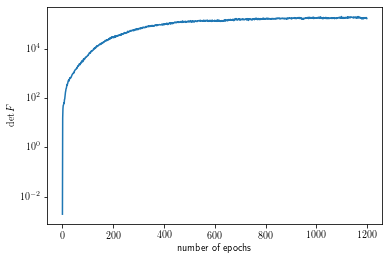

A GA mean: 0.0018472671508789062 +\- 0.11237556487321854
A_fid: 0.8500000238418579
B GA mean: 0.8864985704421997 +\- 0.055763907730579376
B_fid: 0.75


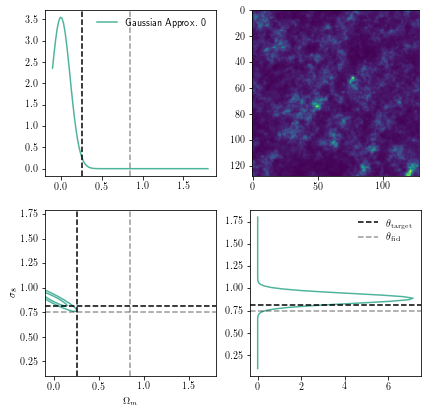

GA estimate moved more than 3.0 sigma away from θ_fid: retraining
training IMNN for iteration 1


/mnt/home/tmakinen/anaconda3/envs/pyjax9/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


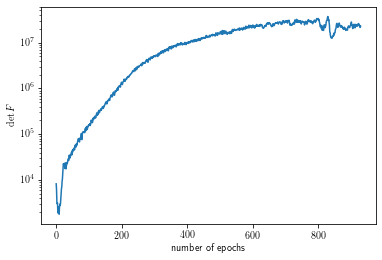

A GA mean: 0.06572304666042328 +\- 0.001005929196253419
A_fid: 0.0018472671508789062
B GA mean: -1.8307312726974487 +\- 0.21499797701835632
B_fid: 0.8864985704421997


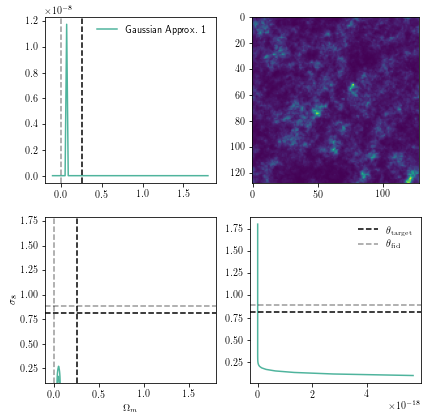

GA estimate moved more than 3.0 sigma away from θ_fid: retraining
training IMNN for iteration 2


/mnt/home/tmakinen/anaconda3/envs/pyjax9/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [32]:
%%time
# --- SET UP IMNN TRAINING ON WEIRD FIDUCIAL ---
θ_fid = θ_fid

N = simulator_args["N"]
shape = simulator_args["shape"]

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) *2* np.pi / _shape
        for _shape in shape)))**2, axis=0))



# save IMNNs:
IMNN_chain = []
ABC_chain = []

# save posteriors
posterior_chains = []

# --- CHOOSE PRIOR --- 
prior = uniform([-0.1, 0.1], [1.8, 1.8])

# --- SET UP TRAINING ARGS ---
simulator_args = {'N': N,
                 'L': L,
                 'dim': 2,
                 'shape': (N, N),
                 'N_scale': False,
                 'vol_norm': True,
                 'squeeze': False}

# --- GENERATE TARGET DATA ---
rng, key = jax.random.split(rng)

# --- CHOOSE CRITERION FOR RETRANING ---
criterion = 3.0


# --- RUN TRAINING LOOP ---
IMNN_chain = iterative_training(target_data, IMNN_chain, θ_fid, θ_target, 
                                    prior, rng, criterion=criterion, kbin=kbin[1:N//2, 1:N//2],
                                   start_with_last=False, do_train=True)

In [41]:
# take last IMNN and do ABC with it:
# smaller prior ???
prior = uniform([0.1, 0.1], [2.0, 2.0])

IMNN = IMNN_chain[-1]
ABC = ApproximateBayesianComputation(
        target_data, prior, 
     lambda A,B : simulator(A,B, simulator_args={**simulator_args, **{'squeeze':False}}), 
                                       IMNN.get_estimate, F=IMNN.F, gridsize=50
    )

for i in range(1):
    rng,abc_key = jax.random.split(rng)
    ABC(rng=abc_key,
            n_samples=int(1e3),
            min_accepted=15000,
            max_iterations=20000,
            ϵ=0.05,
            smoothing=0.5)


1651 accepted in last  20000 iterations  (20000000 simulations done).


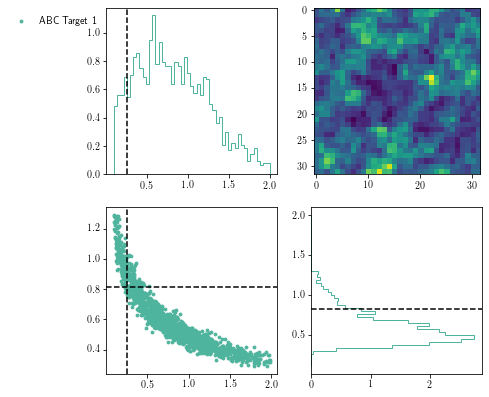

In [45]:
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))

ABC.scatter_plot(ax=ax, colours=new_colors[2], s=8,
    axis_labels=[r"$\Omega_m$", r"$\sigma_8$"], label='ABC', ncol=1)

ax[0,1].imshow(np.squeeze(target_data))

ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

In [98]:
IMNNs = [IMNN]

In [115]:
np.linalg.det(IMNNs[0].F) #/ (detf_expected)

DeviceArray(1102.1112, dtype=float32)

In [132]:
IMNNs[0].F

DeviceArray([[ 63.554317, 125.68003 ],
             [125.68003 , 265.87622 ]], dtype=float32)

In [133]:
print('IMNN F:', IMNN.F)

print('IMNN det F:', np.linalg.det(IMNN.F))

print('IMNN F / analytic det F: ', (np.linalg.det(IMNN.F)) / detF_expected)

IMNN F: [[ 63.554317 125.68003 ]
 [125.68003  265.87622 ]]
IMNN det F: 1102.1112
IMNN F / analytic det F:  0.77711844


# Data for ABC example

In [134]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = np.array(jax.random.split(
            seed, 
            num=len(self.event_shape)))
        return jax.vmap(
            lambda key, low, high : jax.random.uniform(
                key, 
                shape=(n,), 
                minval=low, 
                maxval=high))(
            keys, self.low, self.high)


In [195]:
prior = uniform([-0.1, -0.1], [2.0, 1.5])

In [196]:
simulator_args

{'N': 32,
 'L': 84,
 'dim': 2,
 'shape': (32, 32),
 'N_scale': False,
 'vol_norm': True,
 'squeeze': True}

# Gaussian approximation

In [197]:
estimates = IMNN.get_estimate(target_data) #[i.get_estimate(target_data) for i in IMNNs];

In [198]:
estimates

DeviceArray([[0.86209893, 0.451454  ]], dtype=float32)

In [199]:
GAs = [GaussianApproximation(IMNN.get_estimate(target_data), IMNN.invF, prior)]
       #GaussianApproximation(get_estimate(target_data), np.linalg.inv(f_expected), prior)]

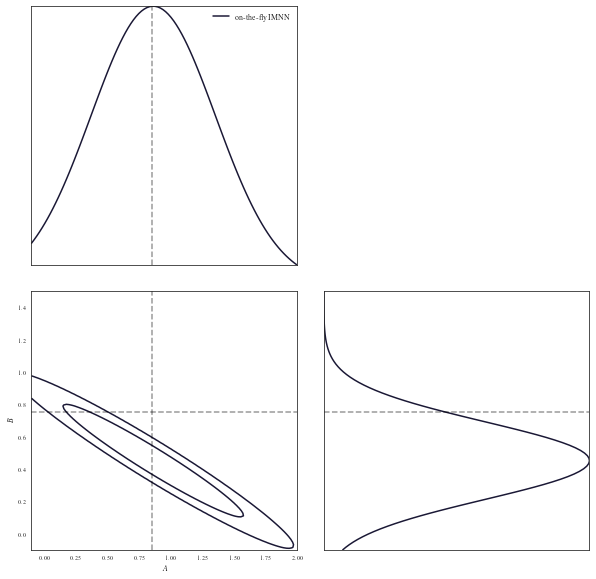

In [200]:
%matplotlib inline
for i, (GA, label) in enumerate(zip(GAs, ['sim IMNN'])):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$A$", r"$B$"], label='on-the-fly IMNN', colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label='sim IMNN', colours="C{}".format(i), ncol=8)
        
        
ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')


In [205]:
sig_A = np.sqrt(IMNN.invF[0,0])
sig_B = np.sqrt(IMNN.invF[1,1])
print(sig_A)
print(sig_B)

0.4911646
0.24013741


In [207]:
θ_fid

DeviceArray([0.85, 0.75], dtype=float32)

In [210]:
np.abs(np.squeeze(estimates) - θ_fid)

DeviceArray([0.01209891, 0.298546  ], dtype=float32)

In [184]:
GA.marginals[0][0].shape

(1, 100)

In [185]:
GA.marginals[1][0].shape

(1, 100, 100)

In [188]:
GA.marginals[1][1].shape

(1, 100)

(array([2.28760548, 0.36120087, 0.24080058, 0.36120087, 0.36120087,
        0.30100072, 0.36120087, 0.36120087, 0.48160115, 0.90300216]),
 array([1.20326627e-04, 1.66232885e-01, 3.32345444e-01, 4.98458002e-01,
        6.64570561e-01, 8.30683120e-01, 9.96795678e-01, 1.16290824e+00,
        1.32902080e+00, 1.49513335e+00, 1.66124591e+00]),
 [<matplotlib.patches.Polygon at 0x154b9f4a6250>])

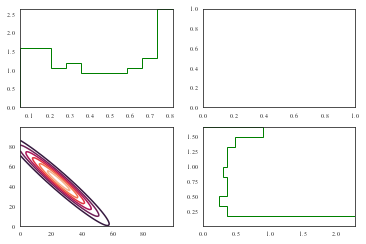

In [193]:
fig,ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].hist(np.squeeze(GA.marginals[0][0]), color='green', histtype='step', density=True)

ax[1,0].contour(np.squeeze(GA.marginals[1][0]))

ax[1,1].hist(np.squeeze(GA.marginals[1][1]), color='green', 
             histtype='step', density=True, orientation='horizontal')

In [178]:
ax[0,0].hist(GA.marginals[0][:, 0], color=new_colors[0], histtype='step', density=True)
ax[1,0].contour(GA.marginals[0][:, 0], GA.marginals[0][:, 1], s=8, alpha=0.6)

ax[1,1].hist(GA.marginals[0][:, 1], color=new_colors[0], 
             histtype='step', density=True, orientation='horizontal')

TypeError: list indices must be integers or slices, not tuple

# ABC

In [211]:
{**simulator_args, **{'squeeze':False}}

{'N': 32,
 'L': 84,
 'dim': 2,
 'shape': (32, 32),
 'N_scale': False,
 'vol_norm': True,
 'squeeze': False}

In [212]:
ABC = ApproximateBayesianComputation(
        target_data, prior, 
     lambda A,B : simulator(A,B, simulator_args={**simulator_args, **{'squeeze':False}}), 
                                       IMNN.get_estimate, F=IMNN.F, gridsize=50
    )

In [ ]:
%%time
rng,abc_key = jax.random.split(rng)
ABC(rng=abc_key,
        n_samples=int(1e3),
        min_accepted=15000,
        max_iterations=50000,
        ϵ=0.01,
        smoothing=0.);

In [123]:
ABC.parameters.accepted[0].shape

(6, 2)

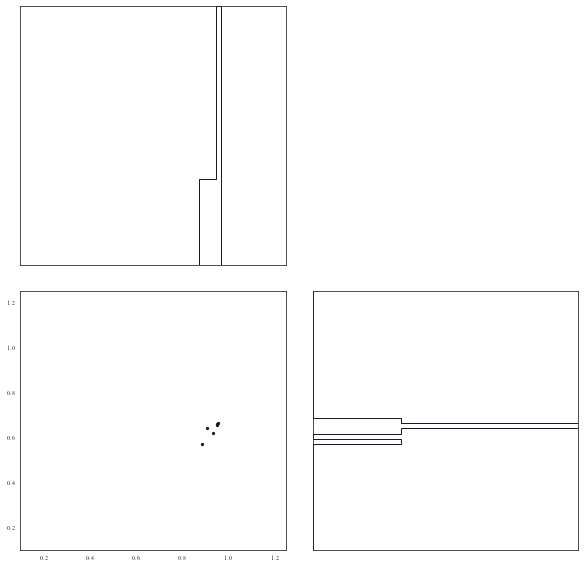

In [124]:
#ax = ABC.scatter_plot(points=ABC.parameters.rejected, colours='red')
ax = ABC.scatter_plot()

In [110]:
#np.save("accepted.npy", ABC.parameters.accepted)

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

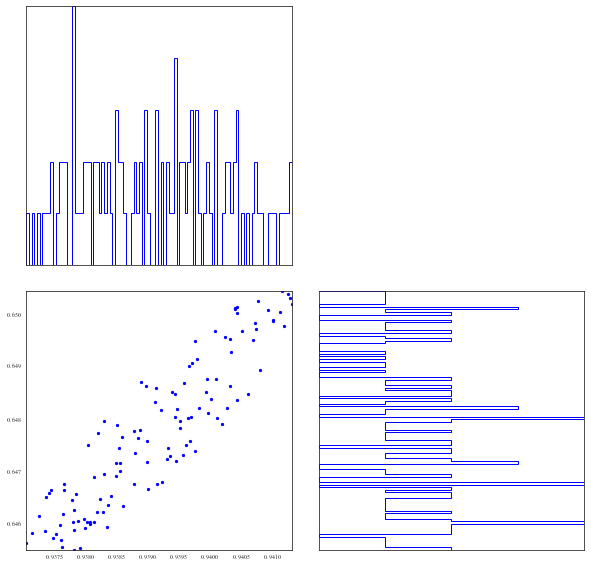

In [68]:
#ax = ABC.scatter_summaries(points=ABC.summaries.rejected, colours='red')
ABC.scatter_summaries( colours='blue')

In [92]:
likelihood, A_range, B_range = AL.get_likelihood(return_grid=True)

likelihoodA = scipy.special.softmax(np.real(likelihood)).sum(0) #np.real(likelihood).sum(0)
likelihoodA /= likelihoodA.sum() * (A_range[1] -  A_range[0])
likelihoodB =  scipy.special.softmax(np.real(likelihood)).sum(1) #np.real(likelihood).sum(1)
likelihoodB /= likelihoodB.sum() * (B_range[1] -  B_range[0])

likelihood = scipy.special.softmax(np.real(likelihood))
sorted_marginal = np.sort(likelihood.flatten())[::-1]
cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
value = []
for level in [0.997, 0.95, 0.68]:
    this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
    if len(value) == 0:
        value.append(this_value)
    elif this_value <= value[-1]:
        break
    else:
        value.append(this_value)
        

computing likelihood on a 100x100 grid 
         in tiles of size 20x20
shift -4532.025436777502
loglike mean -5978.304368706474


In [93]:
value

[DeviceArray(6.23561762e-05, dtype=float64),
 DeviceArray(0.0011216, dtype=float64),
 DeviceArray(0.00759658, dtype=float64)]

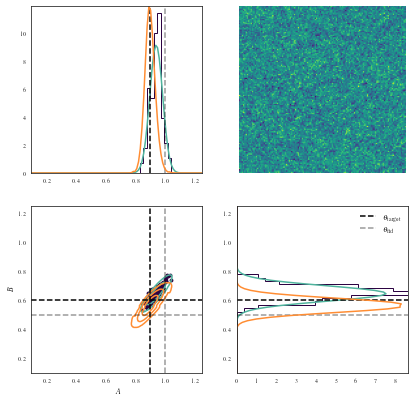

In [94]:
%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
latexify(fig_width=3.37, fig_height=3.37)

ABC.scatter_plot(ax=ax,
                      colours=new_colors[0], 
                      axis_labels=[r"$A$", r"$B$"], 
                      s=8,
                      label='ABC estimate')
# ABC.marginal_plot(ax=ax,
#             axis_labels=[r"$A$", r"$B$"], colours='green',
#             label='ABC marginal plot')


GAs[0].marginal_plot(ax=ax, colours=new_colors[2], axis_labels=[r"$A$", r"$B$"], label=None, ncol=1)
ax[0,1].imshow(np.squeeze(target_data), cmap='viridis')

#ax[0,1].set_title(r'$\theta_{\rm target} = A,B = (%.2f,%.2f)$'%(θ_target[0], θ_target[1]))

ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$A$')
ax[1,0].set_ylabel(r'$B$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
#ax[1,0].contourf(A_range, B_range, L1.reshape((size, size)))
#ax[0, 0].plot(A_range, np.real(loglikeA), color='g', label='loglikeA')

ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

ax[1,1].legend(framealpha=0.)


# add in the likelihood estimate
ax[0, 0].plot(A_range, likelihoodA, color='#FF8D33', label=None)
ax[0, 1].axis("off")
ax[1, 0].contour(A_range, B_range, likelihood, levels=value, colors='#FF8D33')
ax[1, 1].plot(likelihoodB, B_range, color='#FF8D33', label='loglike')

ax[0,0].legend(framealpha=0.)

#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-contours.png', dpi=400)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [116]:
# do PMC-ABC
import tensorflow_probability
tfp = tensorflow_probability.experimental.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

In [143]:
def new_ABC(rng, n_points, proposal_distribution, simulator, data_summary, f, n_parallel_simulations=None, simulator_parameters=None):
    def get_distance(summaries, data_summary, f):
        if len(data_summary.shape) > 1:
            return jax.vmap(lambda data_summary, f : get_distance(summaries, data_summary, f))(data_summary, f)
        if len(summaries.shape) == 1:
            difference = summaries - data_summary
            distance = difference.dot(f).dot(difference)
            return jax.lax.cond(np.isnan(distance), lambda _ : np.inf, lambda distance : distance, distance)
        elif len(summaries.shape) == 2:
            return jax.vmap(lambda summaries : get_distance(summaries, data_summary, f), out_axes=-1)(summaries)
        else:
            return jax.vmap(lambda summaries : get_distance(summaries, data_summary, f), out_axes=-2)(summaries)
    shape = (n_points,)
    if n_parallel_simulations is not None:
        shape = shape + (n_parallel_simulations,)
    rng, key = jax.random.split(rng)
    proposed = proposal_distribution.sample(shape, seed=key)
    key = jax.random.split(rng, num=np.prod(np.array(proposed).shape[:-1]))
    summaries = simulator(key.reshape(proposed.shape[:-1] + (2,)), proposed, simulator_parameters=simulator_parameters)
    distances = get_distance(summaries, data_summary, f)
    return proposed, summaries, distances

In [144]:
def w_cov(proposed, weighting):
    weighted_samples = proposed * weighting[:, np.newaxis]
    return weighted_samples.T.dot(weighted_samples) / weighting.T.dot(weighting)

In [145]:
class tmvn():
    def __init__(self, loc, scale, low, high, max_counter=int(1e3)):
        self.loc = loc
        self.scale = scale
        self.low = low
        self.high = high
        if len(loc.shape) > 1:
            self.n_samples = loc.shape[0]
        else:
            self.n_samples = None
        self.n_params = low.shape[0]
        self.max_counter = max_counter

    def mvn(self, rng, loc):
        u = jax.random.normal(rng, shape=(self.n_params,))
        return loc + u.dot(self.scale)

    def w_cond(self, args):
        _, loc, counter = args
        return np.logical_and(
            np.logical_or(
                np.any(np.greater(loc, self.high)),
                np.any(np.less(loc, self.low))),
            np.less(counter, self.max_counter))

    def __sample(self, args):
        rng, loc, counter = args
        rng, key = jax.random.split(rng)
        return (rng, self.mvn(key, loc), counter+1)

    def _sample(self, rng, loc):
        rng, key = jax.random.split(rng)
        _, loc, counter = jax.lax.while_loop(
            self.w_cond, 
            self.__sample, 
            (rng, self.mvn(key, loc), 0))
        return jax.lax.cond(
            np.greater_equal(counter, self.max_counter),
            lambda _ : np.nan * np.ones((self.n_params,)),
            lambda _ : loc,
            None)

    def _sample_n(self, rng, loc, n=None):
        if n is None:
            return self._sample(rng, loc)
        else:
            key = jax.random.split(rng, num=n)
            return jax.vmap(self._sample)(key, 
                np.repeat(loc[np.newaxis], n, axis=0))

    def sample(self, shape=None, seed=None):
        if shape is None:
            if self.n_samples is None:
                return self._sample_n(seed, self.loc)
            else:
                key = jax.random.split(seed, num_self.n_samples)
                return jax.vmap(lambda key, loc : self._sample_n(key, loc))(key, self.loc)
        elif len(shape) == 1:
            if self.n_samples is None:
                return self._sample_n(seed, self.loc, n=shape[0])
            else:
                key = jax.random.split(seed, num_self.n_samples)
                return jax.vmap(lambda key, loc : self._sample_n(key, loc, n=shape[0]))(key, self.loc)
        else:
            key = jax.random.split(seed, num=shape[-1])
            return jax.vmap(lambda key: self.sample(shape=tuple(shape[:-1]), seed=key), out_axes=-2)(key)

In [146]:
def PMC(rng, n_initial_points, n_points, prior, simulator, data_summary, f, percentile=75, acceptance_ratio=0.1, 
        max_iteration=10, max_acceptance=10, max_samples=int(1e3), n_parallel_simulations=None, simulator_parameters=None):
    low = np.array([dist.low for dist in prior.distributions])
    high = np.array([dist.high for dist in prior.distributions])
    def single_PMC(rng, samples, summaries, distances, weighting, data_summary, f):
        def single_iteration_condition(args):
            return np.logical_and(
                np.greater(args[-3], acceptance_ratio),
                np.less(args[-2], max_iteration))
        def single_iteration(args):
            def single_acceptance_condition(args):
                return np.logical_and(
                    np.less(args[-2], 1),
                    np.less(args[-1], max_acceptance))
            def single_acceptance(args):
                rng, loc, summ, dist, draws, accepted, acceptance_counter = args
                #rng, loc, summ, dist, draws, rejected, acceptance_counter = args
                rng, key = jax.random.split(rng)
                proposed, summaries, distances = new_ABC(
                    key, None, tmvn(loc, scale, low, high, max_counter=max_samples),
                    simulator, data_summary, f, n_parallel_simulations=n_parallel_simulations,
                    simulator_parameters=simulator_parameters)
                if n_parallel_simulations is not None:
                    min_distance_index = np.argmin(distances)
                    min_distance = distances[min_distance_index]
                    closer = np.less(min_distance, ϵ)
                    loc = jax.lax.cond(closer, lambda _ : proposed[min_distance_index], lambda _ : loc, None)
                    summ = jax.lax.cond(closer, lambda _ : summaries[min_distance_index], lambda _ : summ, None)
                    dist = jax.lax.cond(closer, lambda _ : distances[min_distance_index], lambda _ : dist, None)
                    iteration_draws = n_parallel_simulations - np.isinf(distances).sum()
                    draws += iteration_draws 
                    accepted = closer.sum()
                    #rejected = iteration_draws - closer.sum()
                else:
                    closer = np.less(distances, dist)
                    loc = jax.lax.cond(closer, lambda _ : proposed, lambda _ : loc, None)
                    summ = jax.lax.cond(closer, lambda _ : summaries, lambda _ : summ, None)
                    dist = jax.lax.cond(closer, lambda _ : distances, lambda _ : dist, None)
                    iteration_draws = 1 - np.isinf(distances).sum()
                    draws += iteration_draws
                    accepted = closer.sum()
                    #rejected = iteration_draws - closer.sum()
                return (rng, loc, summ, dist, draws, accepted, acceptance_counter+1)
                #return (rng, loc, summ, dist, draws, rejected, acceptance_counter+1)

            rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter, total_draws = args
            ϵ = distances[ϵ_ind]
            loc = samples[ϵ_ind:]
            cov = w_cov(samples, weighting)
            inv_cov = np.linalg.inv(cov)
            scale = np.linalg.cholesky(cov)
            rng, *key = jax.random.split(rng, num=loc.shape[0]+1)
            draws = np.zeros(loc.shape[0], dtype=np.int32)
            accepted = np.zeros(loc.shape[0], dtype=np.int32)
            #rejected = np.zeros(loc.shape[0], dtype=np.int32)
            acceptance_counter = np.zeros(loc.shape[0], dtype=np.int32)

            results = jax.vmap(
                lambda key, loc, summaries, distances, draws, accepted, acceptance_counter : jax.lax.while_loop(
                #lambda key, loc, summaries, distances, draws, rejected, acceptance_counter : jax.lax.while_loop(
                    single_acceptance_condition, single_acceptance, (key, loc, summaries, distances, draws, accepted, acceptance_counter)))(
                    #single_acceptance_condition, single_acceptance, (key, loc, summaries, distances, draws, rejected, acceptance_counter)))(
                np.array(key), loc, summaries[ϵ_ind:], distances[ϵ_ind:], draws, accepted, acceptance_counter)
                #np.array(key), loc, summaries[ϵ_ind:], distances[ϵ_ind:], draws, rejected, acceptance_counter)

            weighting = jax.vmap(
                lambda proposed : (
                    prior.prob(proposed) 
                    / (np.sum(weighting * tfd.MultivariateNormalTriL(
                        loc=samples,
                        scale_tril=np.repeat(
                            scale[np.newaxis], 
                            samples.shape[0], 
                            axis=0)).prob(proposed)))))(
                    np.vstack([samples[:ϵ_ind], results[1]]))
            samples = jax.ops.index_update(samples, jax.ops.index[ϵ_ind:, :], results[1])
            summaries = jax.ops.index_update(summaries, jax.ops.index[ϵ_ind:, :], results[2])
            distances = jax.ops.index_update(distances, jax.ops.index[ϵ_ind:], results[3])
            acceptance_reached = results[-2].sum() / results[-3].sum()
            return (rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter+1, total_draws+results[-3].sum())

        acceptance_reached = np.inf
        iteration_counter = 0
        total_draws = 0
        results = jax.lax.while_loop(
            single_iteration_condition, 
            single_iteration, 
            (rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter, total_draws))
        return results[1], results[2], results[3], results[4], results[7], results[8], results[9]

    rng, key = jax.random.split(rng)
    proposed, summaries, distances = new_ABC(
        key, n_initial_points, prior, simulator, data_summary, f, 
        n_parallel_simulations=n_parallel_simulations, simulator_parameters=simulator_parameters)

    if n_parallel_simulations is not None:
        proposed = proposed.reshape((n_initial_points * n_parallel_simulations, -1))
        summaries = summaries.reshape((n_initial_points * n_parallel_simulations, -1))
        if len(data_summary.shape) > 1:
            distances = distances.reshape((data_summary.shape[0], -1))
        else:
            distances = distances.reshape((-1,))

    if len(data_summary.shape) == 1:
        sample_indices = np.argsort(distances)[:n_points]
        samples = proposed[sample_indices]
        summaries = summaries[sample_indices]
        distances = distances[sample_indices]
    else:
        sample_indices = np.argsort(distances, axis=1)[:, :n_points]
        samples = jax.vmap(lambda x: proposed[x])(sample_indices)
        summaries = jax.vmap(lambda x: summaries[x])(sample_indices)
        distances = np.take_along_axis(distances, sample_indices, axis=1)    

    weighting = prior.prob(samples)

    if percentile is None:
        ϵ_ind = -1
        to_accept = 1
    else:
        ϵ_ind = int(percentile / 100 * n_points)
        to_accept = n_points - ϵ_ind

    if len(data_summary.shape) == 1:
        return single_PMC(rng, samples, summaries, distances, weighting, data_summary, f)
    else:
        key = jax.random.split(rng, num=data_summary.shape[0])
        return jax.vmap(single_PMC)(key, samples, summaries, distances, weighting, data_summary, f)

In [147]:
targe_data_summary = get_estimate(target_data)

In [148]:
low = np.array([0.1, 0.1])
high = np.array([2., 2.])
myprior = tfd.Blockwise([tfd.Uniform(low=low[i], high=high[i]) for i in range(low.shape[0])])

In [149]:
rng, key = jax.random.split(rng)
ppmc_prop, ppmc_summ, ppmc_dist, ppmc_w, ppmc_crit, ppmc_it, ppmc_draws = PMC(
    rng=key, n_initial_points=1000, n_points=250, prior=myprior, simulator=simulator, 
    data_summary=targe_data_summary, f=IMNN.F, percentile=75, acceptance_ratio=0.5, 
    max_iteration=int(1e2), max_acceptance=int(1e3), max_samples=int(1e3), 
    n_parallel_simulations=100, simulator_parameters=(low, high, input_shape))

TypeError: prod requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

In [35]:
# Create figures in Python that handle LaTeX, and save images to files in my
# preferred formatting. I typically place this code in the root of each of my
# projects, and import using:
# from latexify import *
# which will also run the latexify() function on the import.

# Based on code from https://nipunbatra.github.io/blog/2014/latexify.html

import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

#Back-end to use depends on the system
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
# matplotlib.use('pgf')
# from matplotlib.backends.backend_pgf import FigureCanvasPgf
# matplotlib.backend_bases.register_backend('ps', FigureCanvasPgf)

import seaborn as sns
sns.set_style("white")

#my preferred palette. From
#https://seaborn.pydata.org/tutorial/color_palettes.html: "The cubehelix color
#palette system makes sequential palettes with a linear increase or decrease in
#brightness and some variation in hue. This means that the information in your
#colormap will be preserved when converted to black and white (for printing) or
#when viewed by a colorblind individual."

# I typically set the number of colors (below, 8) to the distinct colors I need
# in a given plot, so as to use the full range.
sns.set_palette(sns.color_palette("cubehelix", 8))


# The following is the latexify function. It allows you to create 2 column or 1
# column figures. You may also wish to alter the height or width of the figure.
# The default settings are good for most cases. You may also change the
# parameters such as labelsize and fontsize based on your classfile.
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1, 2])

    if fig_width is None:
        fig_width = 6.9 if columns == 1 else 13.8  # width in inches #3.39

    if fig_height is None:
        golden_mean = (sqrt(5) - 1.0) / 2.0    # Aesthetic ratio
        fig_height = fig_width * golden_mean  # height in inches

    MAX_HEIGHT_INCHES = 16.0
    if fig_height > MAX_HEIGHT_INCHES:
        print(("WARNING: fig_height too large:" + fig_height +
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches."))
        fig_height = MAX_HEIGHT_INCHES

    params = {
            # 'backend': 'ps',
           #   'pgf.rcfonts': False,
           #   'pgf.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
           #   "pgf.texsystem": "pdflatex",
             # 'text.latex.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
              'text.latex.preamble': '\\usepackage{mathptmx}',
              #values below are useful defaults. individual plot fontsizes are
              #modified as necessary.
              'axes.labelsize': 8,  # fontsize for x and y labels
              'axes.titlesize': 8,
              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 6,
              'ytick.labelsize': 6,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'font.serif': 'Times',
               'lines.linewidth': 1.5,
               'lines.markersize':1,
               'xtick.major.pad' : 2,
               'ytick.major.pad' : 2,
                'axes.xmargin' :  .0,  # x margin.  See `axes.Axes.margins`
                'axes.ymargin' : .0,  # y margin See `axes.Axes.margins`
              }

    matplotlib.rcParams.update(params)

def saveimage(name, fig = plt, extension = 'pdf', folder = 'plots/'):
    sns.despine()

    #Minor ticks off by default in matplotlib
    # plt.minorticks_off()

    #grid being off is the default for seaborn white style, so not needed.
    # plt.grid(False, axis = "x")
    # plt.grid(False, axis = "y")
    
    fig.savefig('{}{}.{}'.format(folder,name, extension), bbox_inches = 'tight')

latexify()